In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import aux_funcs

## Collect data from 3 different containers

30: entropy bitshuffle (split)

0: blosclz bitshuffle split

1: zstd bitshuffle split

In [2]:
paths = [Path('../data_inputs_temp/'),
         Path('../data_inputs'),
         Path('../data_inputs_wind/')]

files = ['entropy-bitshuffle', 'blosclz-bitshuffle-split', 'zstd-bitshuffle-split']
categories = ["30", "0", "1"]

df_entropy = aux_funcs.get_df_by_category(paths, files[0], categories[0])
df_blosclz = aux_funcs.get_df_by_category(paths, files[1], categories[1])
df_zstd = aux_funcs.get_df_by_category(paths, files[2], categories[2])

# Filter data

Delete data corresponding to special values chunks.

In [3]:
df_bitshuffle = pd.concat([df_blosclz, df_zstd, df_entropy], axis=1)
df_bitshuffle = aux_funcs.delete_special_vals(df_bitshuffle, ["special_vals0", "special_vals1", "special_vals30"])
df_input_x = df_bitshuffle.iloc[:, [6, 7]]

## GRÀFICS

## Diagrama tija i fulles

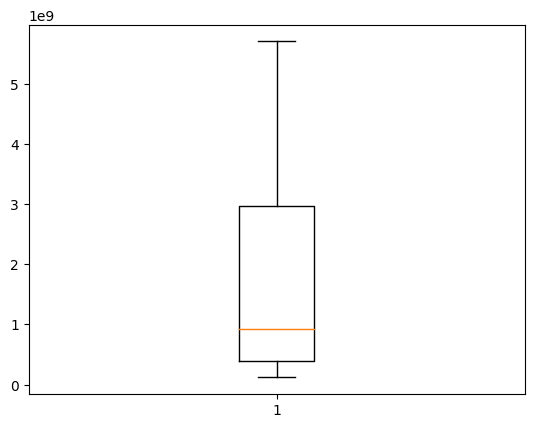

In [4]:
plt.boxplot(df_bitshuffle['speed0'])
plt.show()

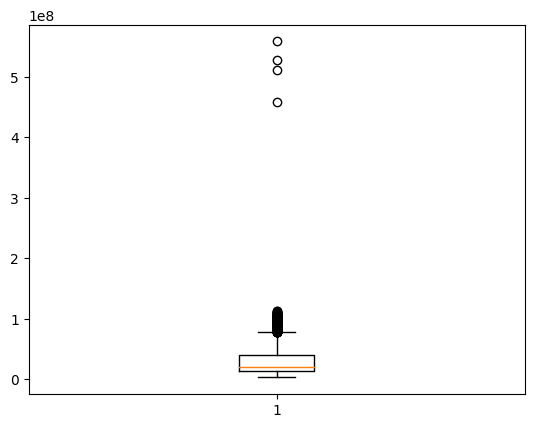

In [5]:
plt.boxplot(df_bitshuffle['speed1'])
plt.show()

In [6]:
# hi ha dades atípiques, es lleven

q1 = np.percentile(df_bitshuffle['speed1'], 25,
                   method='midpoint')
q3 = np.percentile(df_bitshuffle['speed1'], 75,
                   method='midpoint')
iqr = q3 - q1
lim_sup = q3 + 1.5 * iqr

df_bitshuffle = df_bitshuffle[df_bitshuffle.speed1 <= lim_sup]

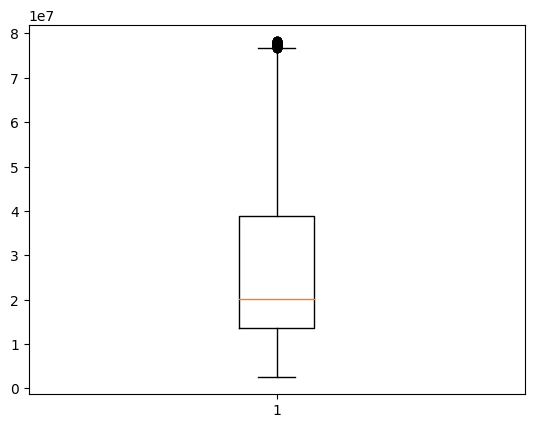

In [7]:
plt.boxplot(df_bitshuffle['speed1'])
plt.show()

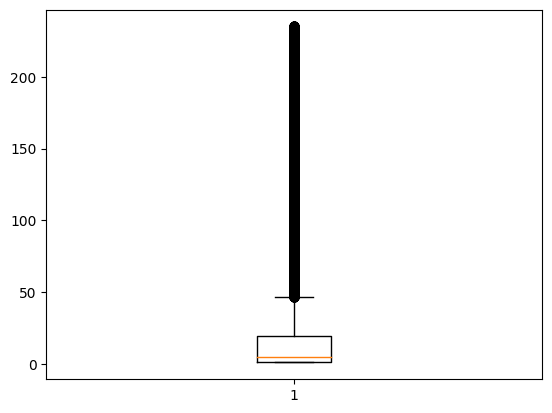

In [8]:
plt.boxplot(df_bitshuffle['cratio0'])
plt.show()

In [9]:
# hi ha dades atípiques, es lleven

q1 = np.percentile(df_bitshuffle['cratio0'], 25,
                   method='midpoint')
q3 = np.percentile(df_bitshuffle['cratio0'], 75,
                   method='midpoint')
iqr = q3 - q1
lim_sup = q3 + 1.5 * iqr

df_bitshuffle = df_bitshuffle[df_bitshuffle.cratio0 <= lim_sup]

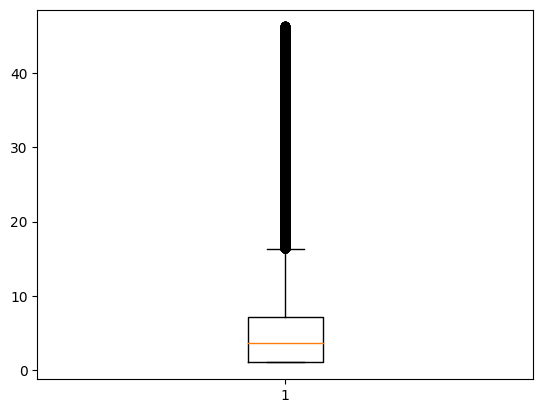

In [10]:
plt.boxplot(df_bitshuffle['cratio0'])
plt.show()

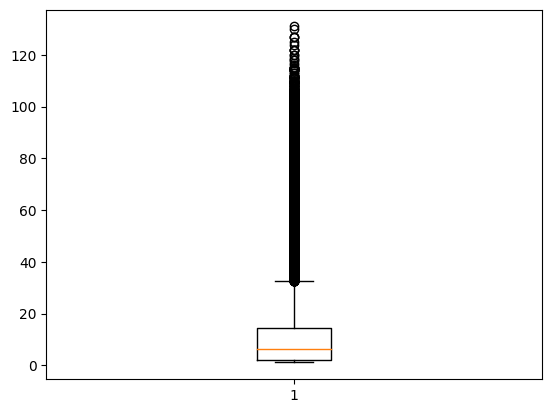

In [11]:
plt.boxplot(df_bitshuffle['cratio1'])
plt.show()

In [12]:
# hi ha dades atípiques, es lleven

q1 = np.percentile(df_bitshuffle['cratio1'], 25,
                   method='midpoint')
q3 = np.percentile(df_bitshuffle['cratio1'], 75,
                   method='midpoint')
iqr = q3 - q1
lim_sup = q3 + 1.5 * iqr

df_bitshuffle = df_bitshuffle[df_bitshuffle.cratio1<= lim_sup]

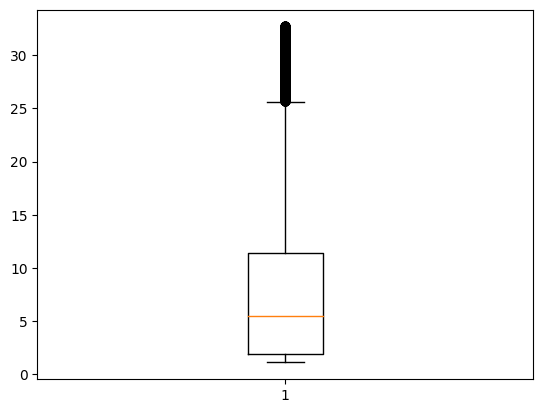

In [13]:
plt.boxplot(df_bitshuffle['cratio1'])
plt.show()


## Compute best category

In [14]:
df_codecs = df_bitshuffle.iloc[:, [0, 1, 3, 4]]
df_codecs.head()

,cratio0,speed0,cratio1,speed1
1,1.00,1.930000e+09,3.37,10500000.0
2,5.67,3.830000e+08,13.90,17700000.0
5,1.00,1.940000e+09,3.34,10800000.0
6,6.34,4.580000e+08,14.90,19400000.0
9,1.00,1.980000e+09,3.54,10900000.0


### Normalize cratio and speed

In [15]:
dfcratios = pd.concat([df_codecs.iloc[:, 0], df_codecs.iloc[:, 2]], axis=0)
mean_cratio = dfcratios.mean()

cratio0 = df_codecs["cratio0"]
cratio1 = df_codecs["cratio1"]

ncratio0 = cratio0 - mean_cratio
ncratio1 = cratio1 - mean_cratio
all_cratios = np.concatenate((ncratio0, ncratio1), axis=0)

std_cratio = all_cratios.std()
ncratio0 /= std_cratio
ncratio1 /= std_cratio

In [16]:
dfspeeds = pd.concat([df_codecs.iloc[:, 1], df_codecs.iloc[:, 3]], axis=0)
mean_speed = dfspeeds.mean()

speed0 = df_codecs["speed0"]
speed1 = df_codecs["speed1"]

nspeed0 = speed0 - mean_speed
nspeed1 = speed1 - mean_speed
all_speeds = np.concatenate((nspeed0, nspeed1), axis=0)

dsv_speed = all_speeds.std()
nspeed0 /= dsv_speed
nspeed1 /= dsv_speed

### Compute score to determine which category is the best one

In [17]:
theta_balance = 0.6

df_score_balance = pd.DataFrame()
df_score_balance.insert(0, 0, theta_balance*ncratio0 + (1-theta_balance)*nspeed0)
df_score_balance.insert(1, 1, theta_balance*ncratio1 + (1-theta_balance)*nspeed1)

In [18]:
best_categ_bitshuffle = pd.DataFrame(df_score_balance.idxmax(axis=1), columns=['best_categ'])

In [19]:
categories = best_categ_bitshuffle['best_categ'].unique()
if len(categories) < (len(files) - 1):
    raise ValueError("Not enough categories in training data")

In [20]:
df_input_x.head()

,cratio30,speed30
1,156.00,8.070000e+09
2,1.89,2.420000e+09
3,156.00,1.250000e+10
5,156.00,8.460000e+09
6,1.87,2.450000e+09


In [21]:

df_t = pd.DataFrame()
df_t = pd.concat([df_t, ncratio0], axis=1)
df_t = pd.concat([df_t, nspeed0], axis=1)
df_t = pd.concat([df_t, best_categ_bitshuffle], axis=1)
df_t.head()

,cratio0,speed0,best_categ
1,-0.838138,1.349694,0
2,-0.067340,-0.209733,1
5,-0.838138,1.359774,0
6,0.043246,-0.134131,1
9,-0.838138,1.400095,0


## Split data into training and test

Create a balanced training data with same amount of samples for each (best) category

In [22]:
df_blc = pd.DataFrame()
df_test = pd.DataFrame()
nsamples = min(len(df_t[df_t['best_categ'] == categories[0]]),
               len(df_t[df_t['best_categ'] == categories[1]])) \
           - 2000
if nsamples <= 0:
    raise RuntimeError("not enough data")
for i in categories:
    df_i = df_t[df_t['best_categ'] == i]
    df_blc = pd.concat([df_blc, df_i.head(n=nsamples)], axis=0)
    df_test = pd.concat([df_test, df_i.iloc[nsamples:, :]], axis=0)

In [23]:
df_blc.head()

,cratio0,speed0,best_categ
1,-0.838138,1.349694,0
5,-0.838138,1.359774,0
9,-0.838138,1.400095,0
13,-0.838138,1.279131,0
17,-0.838138,2.357726,0


In [24]:
dftrain_y = df_blc['best_categ']
dftest_y = df_test['best_categ']


dftrain_x = df_blc.drop(['best_categ'], axis=1)
dftest_x = df_test.drop(['best_categ'], axis=1)

# Neural Network with 2 categories

## Build model

In [25]:
from keras.utils import to_categorical
dftrain_y = to_categorical(dftrain_y)
dftest_y = to_categorical(dftest_y)

2023-01-05 10:52:44.441843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
from keras import models, layers
import tensorflow

tensorflow.random.set_seed(100)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(2,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

2023-01-05 10:52:49.920258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

## Train it with data

In [28]:
history = model.fit(dftrain_x, dftrain_y, epochs=40, validation_split=0.1)

Epoch 1/40
1371/1371 [==============================] - 4s 2ms/step - loss: 0.1333 - acc: 0.9633 - val_loss: 0.0245 - val_acc: 0.9986
Epoch 2/40
1371/1371 [==============================] - 3s 2ms/step - loss: 0.0800 - acc: 0.9696 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 3/40
1371/1371 [==============================] - 2s 2ms/step - loss: 0.0793 - acc: 0.9692 - val_loss: 0.0109 - val_acc: 0.9996
Epoch 4/40
1371/1371 [==============================] - 2s 2ms/step - loss: 0.0788 - acc: 0.9698 - val_loss: 0.0118 - val_acc: 0.9996
Epoch 5/40
1371/1371 [==============================] - 2s 2ms/step - loss: 0.0773 - acc: 0.9704 - val_loss: 0.0102 - val_acc: 0.9996
Epoch 6/40
1371/1371 [==============================] - 2s 2ms/step - loss: 0.0764 - acc: 0.9707 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 7/40
1371/1371 [==============================] - 2s 2ms/step - loss: 0.0753 - acc: 0.9713 - val_loss: 0.0126 - val_acc: 0.9996
Epoch 8/40
1371/1371 [==============================] - 2s 2ms

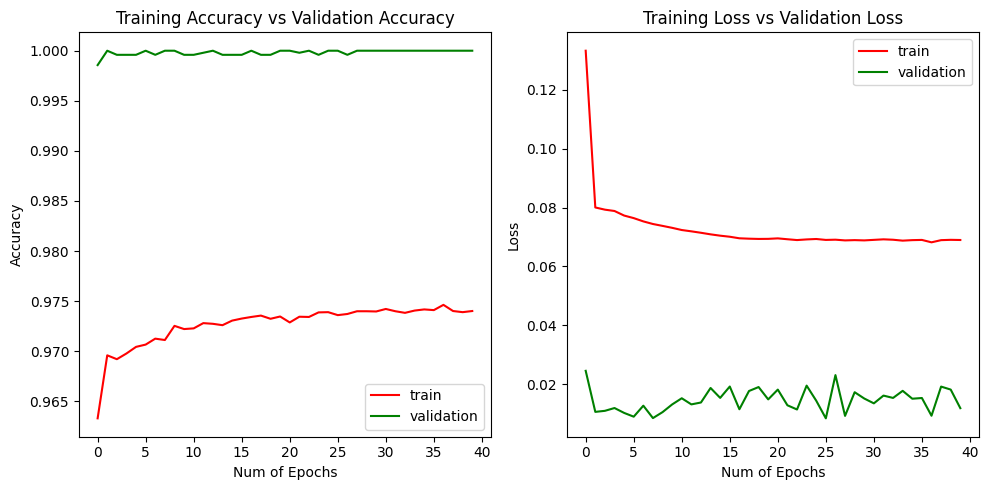

In [29]:
_, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].plot(history.history['acc'], 'r')
ax[0].plot(history.history['val_acc'], 'g')
ax[0].set_xlabel("Num of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Training Accuracy vs Validation Accuracy")
ax[0].legend(['train', 'validation'])

ax[1].plot(history.history['loss'], 'r')
ax[1].plot(history.history['val_loss'], 'g')
ax[1].set_xlabel("Num of Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Training Loss vs Validation Loss")
ax[1].legend(['train', 'validation'])

plt.tight_layout()

## Test it

### Rebuild model

Rebuild model until epoch 5.

In [30]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(2,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(dftrain_x, dftrain_y, epochs=5, validation_split=0.1)

Epoch 1/5
1371/1371 [==============================] - 3s 2ms/step - loss: 0.1391 - acc: 0.9547 - val_loss: 0.0200 - val_acc: 0.9994
Epoch 2/5
1371/1371 [==============================] - 2s 2ms/step - loss: 0.0790 - acc: 0.9703 - val_loss: 0.0097 - val_acc: 1.0000
Epoch 3/5
1371/1371 [==============================] - 2s 2ms/step - loss: 0.0768 - acc: 0.9708 - val_loss: 0.0158 - val_acc: 0.9996
Epoch 4/5
1371/1371 [==============================] - 2s 2ms/step - loss: 0.0753 - acc: 0.9715 - val_loss: 0.0123 - val_acc: 1.0000
Epoch 5/5
1371/1371 [==============================] - 2s 2ms/step - loss: 0.0739 - acc: 0.9716 - val_loss: 0.0142 - val_acc: 0.9996


### Predict train data

In [31]:
y_hat = model.predict(x=dftrain_x)
y_pred_label = np.argmax(y_hat, axis=1)
y_true_label = np.argmax(dftrain_y, axis=1)

1524/1524 [==============================] - 2s 988us/step


In [32]:
table = pd.crosstab(y_pred_label, y_true_label)
table

col_0,0,1
row_0,,
0,23559,401
1,811,23969


In [33]:
(table[0][0] + table[1][1]) / np.sum(table.sum())

0.9751333606893722

### Predict test data

In [34]:
predictions = model.predict(x=dftest_x)
pred_label = np.argmax(predictions, axis=1)
true_label = np.argmax(dftest_y, axis=1)

493/493 [==============================] - 1s 1ms/step


In [35]:
table = pd.crosstab(pred_label, true_label)
table

col_0,0,1
row_0,,
0,1934,849
1,66,12905


In [36]:
aux = np.abs(pred_label - true_label)
fails = np.count_nonzero(aux)

score_balance = (len(aux) - fails) / len(aux)
score_balance

0.9419195125047607

## Retrain model with whole balanced data